# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

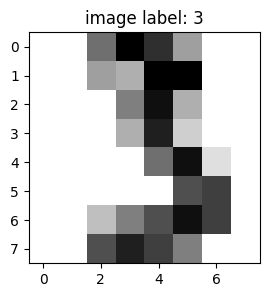

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [10]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [12]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [13]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [14]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [15]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

**YOUR TURN:**

1. Implement the `forward` method of the `LogisticRegression` class. This method should take in a batch of samples `X` and return the predicted probabilities for each class. You should use the softmax function that we implemented earlier.
2. Implement the `loss` method of the `LogisticRegression` class. This method take in the samples `X` and the true values `y` and return the average negative log likelihood of the predictions.

In [16]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = X @ self.W + self.b
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y.astype(int))
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b
    
# Raise an exception if you try to run this cell without having implemented the LogisticRegression class
model = LogisticRegression(input_size=64, output_size=10)
try:
    assert(model.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(model.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the LogisticRegression class.")

In [17]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

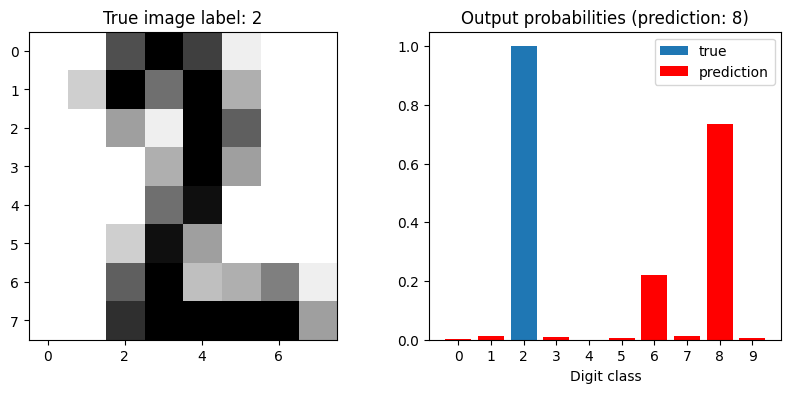

In [18]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)
    

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [19]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps (avoid empty slice at i==0)
    if i > 0 and i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 100: 459
Average NLL over the last 100 samples at step 200: 114
Average NLL over the last 100 samples at step 300: 260
Average NLL over the last 100 samples at step 400: 120
Average NLL over the last 100 samples at step 500: 128
Average NLL over the last 100 samples at step 600: 65
Average NLL over the last 100 samples at step 700: 124
Average NLL over the last 100 samples at step 800: 64
Average NLL over the last 100 samples at step 900: 46
Average NLL over the last 100 samples at step 1000: 82
Average NLL over the last 100 samples at step 1100: 178
Average NLL over the last 100 samples at step 1200: 303
Average NLL over the last 100 samples at step 1300: 158
Average NLL over the last 100 samples at step 1400: 106
Average NLL over the last 100 samples at step 1500: 67


Evaluate the trained model on the first example:

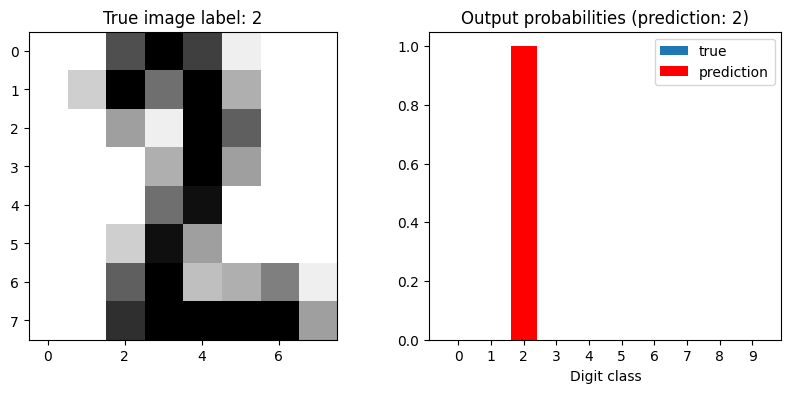

In [20]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

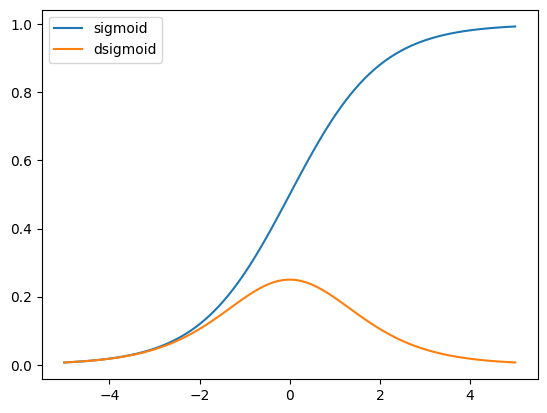

In [21]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    denom = 1 + np.exp(-X)
    return 1 / denom


def dsigmoid(X):
    s = sigmoid(X)
    return s * (1 - s)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [22]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = sigmoid(X @ self.W_h + self.b_h)

        # Apply the sigmoid activation function
        return self.Z_h

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = softmax(H @ self.W_o + self.b_o)

        # Apply the sigmoid activation function
        return self.Z_o

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)

        return Y

    def loss(self, X, y):
        y = y.astype(int)
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        loss = nll(y_onehot, y_pred)
        return loss

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)
    
# Raise an exception if you try to run this cell without having implemented the NeuralNet class
nn = NeuralNet(input_size=64, hidden_size=32, output_size=10)
try:
    assert(nn.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(nn.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the NeuralNet class.")

Once the code is written, we can test our model on a single sample:

In [23]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [24]:
model.loss(X_train, y_train)

np.float64(3538.5294285281598)

In [25]:
model.accuracy(X_train, y_train)

np.float64(0.03929273084479371)

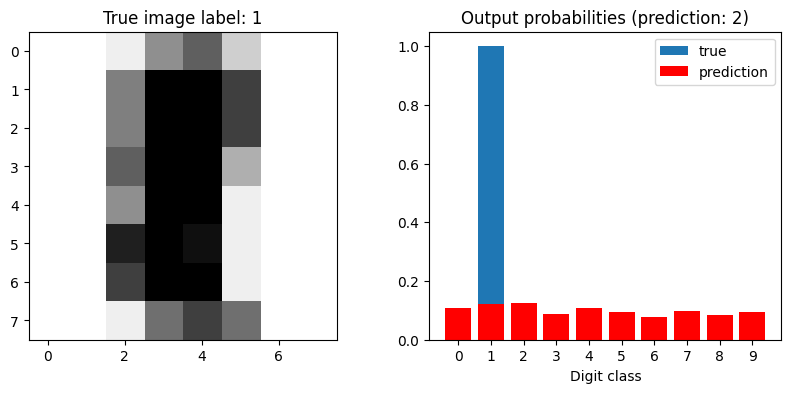

In [26]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [27]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(100):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 3538.52943, train acc: 0.039, test acc: 0.033
Epoch #1, train loss: 3387.59420, train acc: 0.365, test acc: 0.337
Epoch #2, train loss: 3260.12970, train acc: 0.542, test acc: 0.500
Epoch #3, train loss: 3137.84468, train acc: 0.544, test acc: 0.515
Epoch #4, train loss: 3044.17341, train acc: 0.540, test acc: 0.504
Epoch #5, train loss: 2968.70617, train acc: 0.536, test acc: 0.500
Epoch #6, train loss: 2904.74421, train acc: 0.527, test acc: 0.500
Epoch #7, train loss: 2851.50857, train acc: 0.528, test acc: 0.489
Epoch #8, train loss: 2803.10859, train acc: 0.536, test acc: 0.485
Epoch #9, train loss: 2758.75413, train acc: 0.534, test acc: 0.485
Epoch #10, train loss: 2718.97472, train acc: 0.533, test acc: 0.478
Epoch #11, train loss: 2679.46414, train acc: 0.526, test acc: 0.470
Epoch #12, train loss: 2641.00867, train acc: 0.524, test acc: 0.470
Epoch #13, train loss: 2603.97749, train acc: 0.524, test acc: 0.470
Epoch #14, train loss: 2569.71252, train 

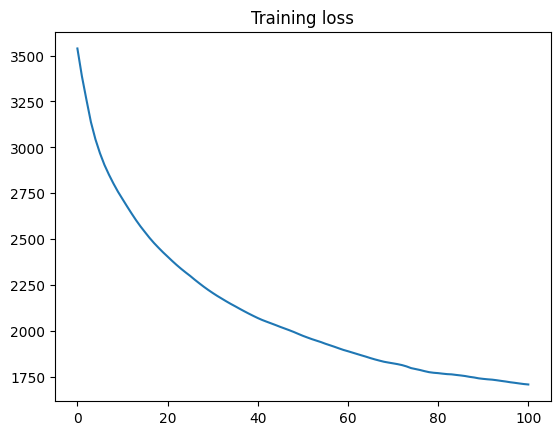

In [28]:
plt.plot(losses)
plt.title("Training loss");

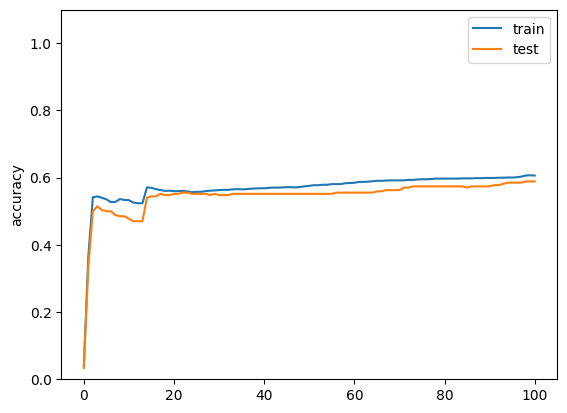

In [29]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

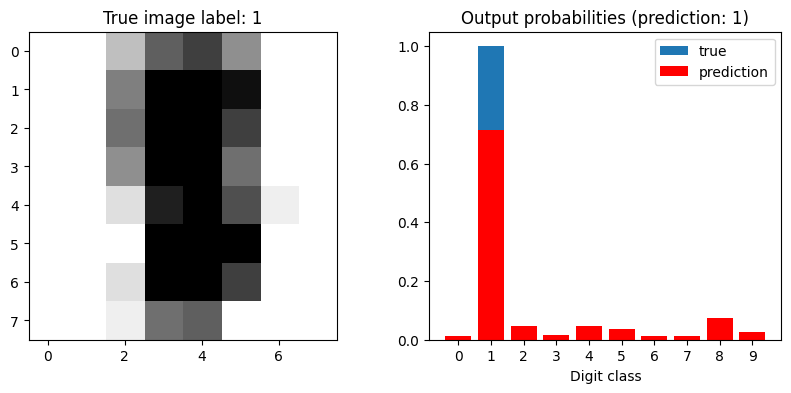

In [30]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

Total number of incorrect predictions: 111 out of 270
Error rate: 41.11%

MOST CONFIDENT WRONG PREDICTIONS (model was very sure, but wrong)


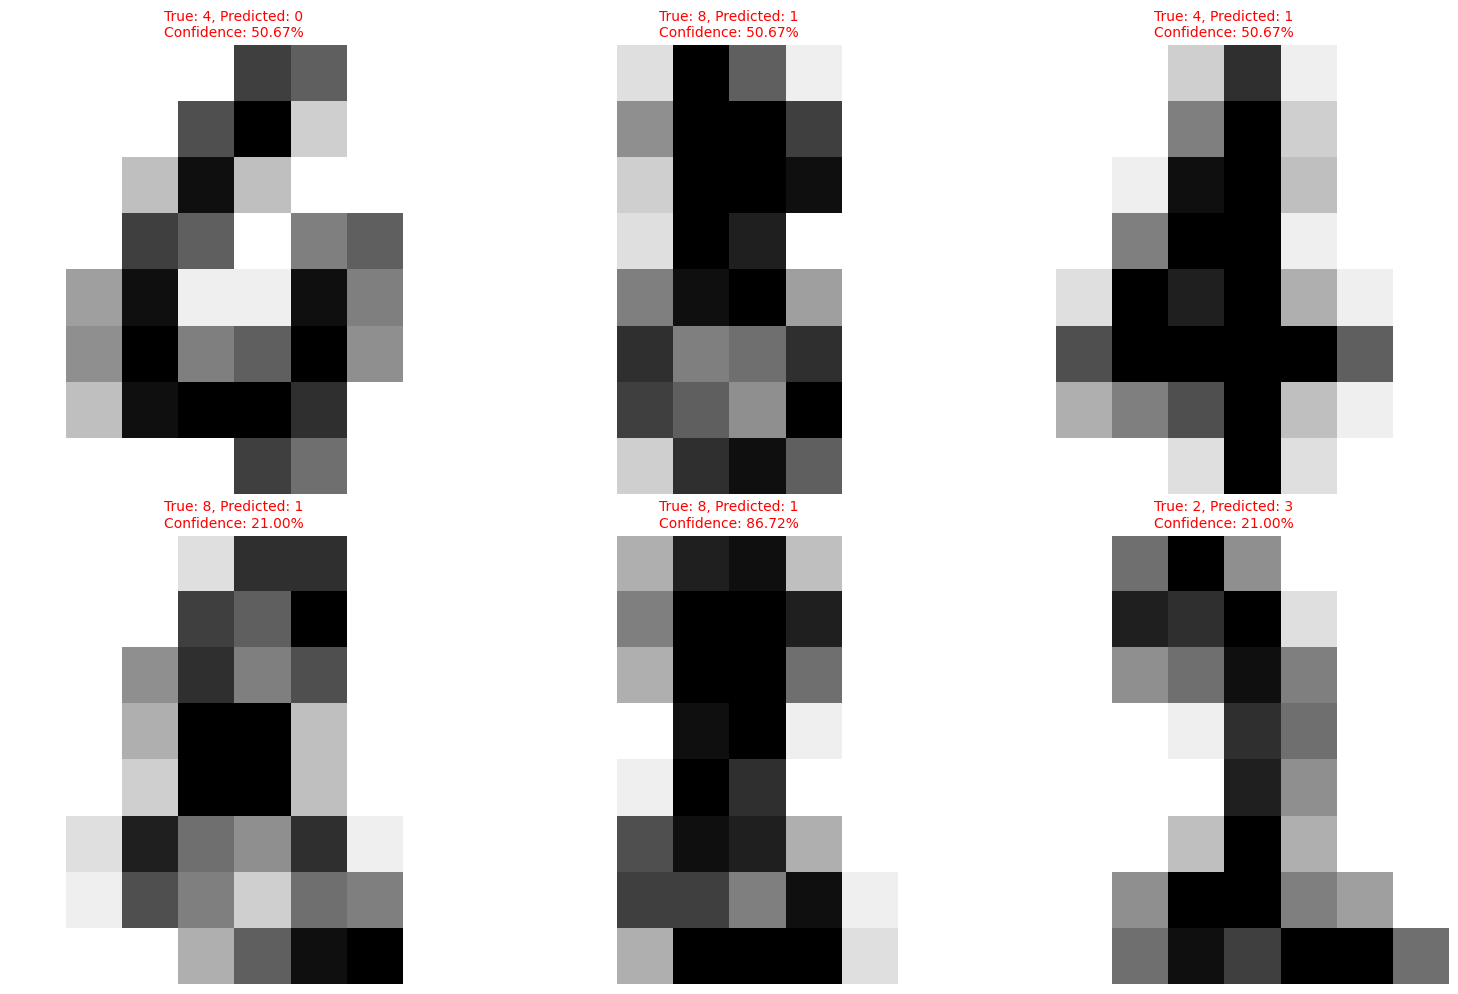


Detailed view of worst predictions (most confident mistakes):

Sample 1:
True label: 4, Predicted: 0, Confidence: 50.67%

Sample 2:
True label: 8, Predicted: 1, Confidence: 50.67%

Sample 3:
True label: 4, Predicted: 1, Confidence: 50.67%

LEAST CONFIDENT WRONG PREDICTIONS (model was unsure and wrong)


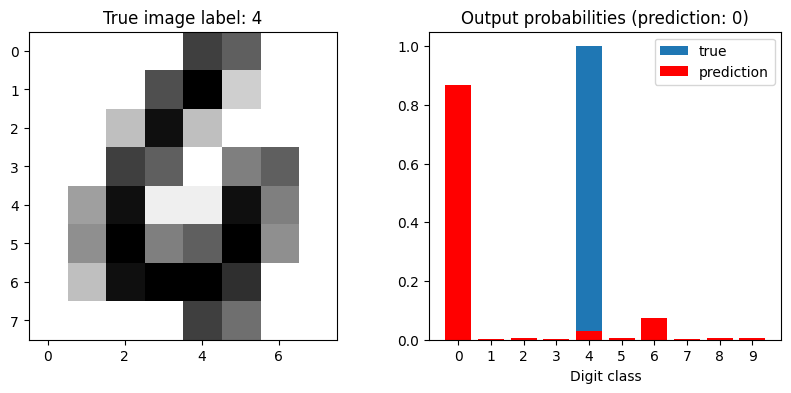

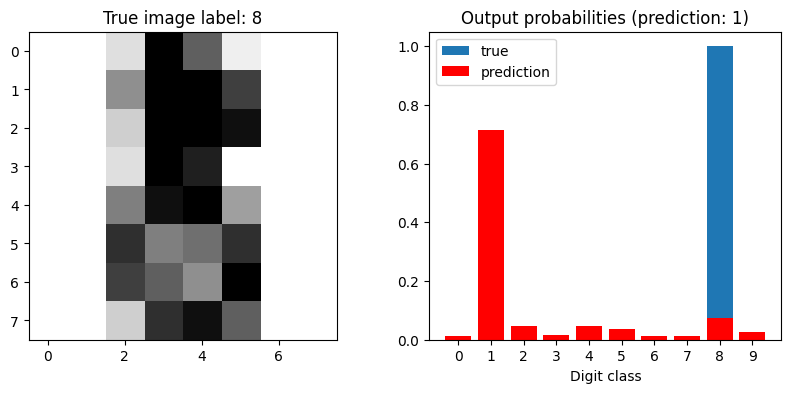

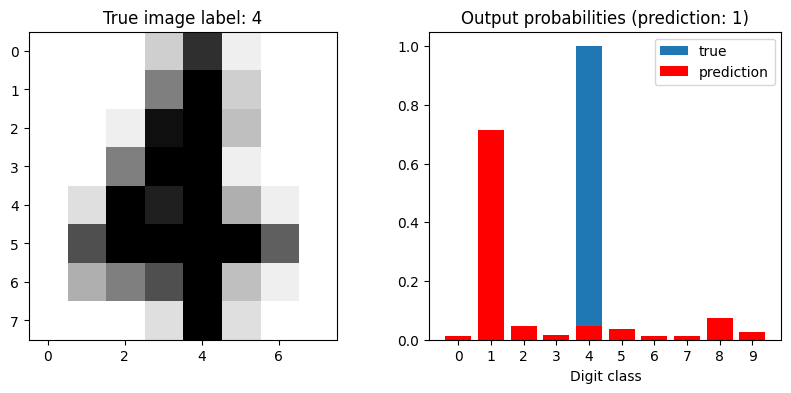

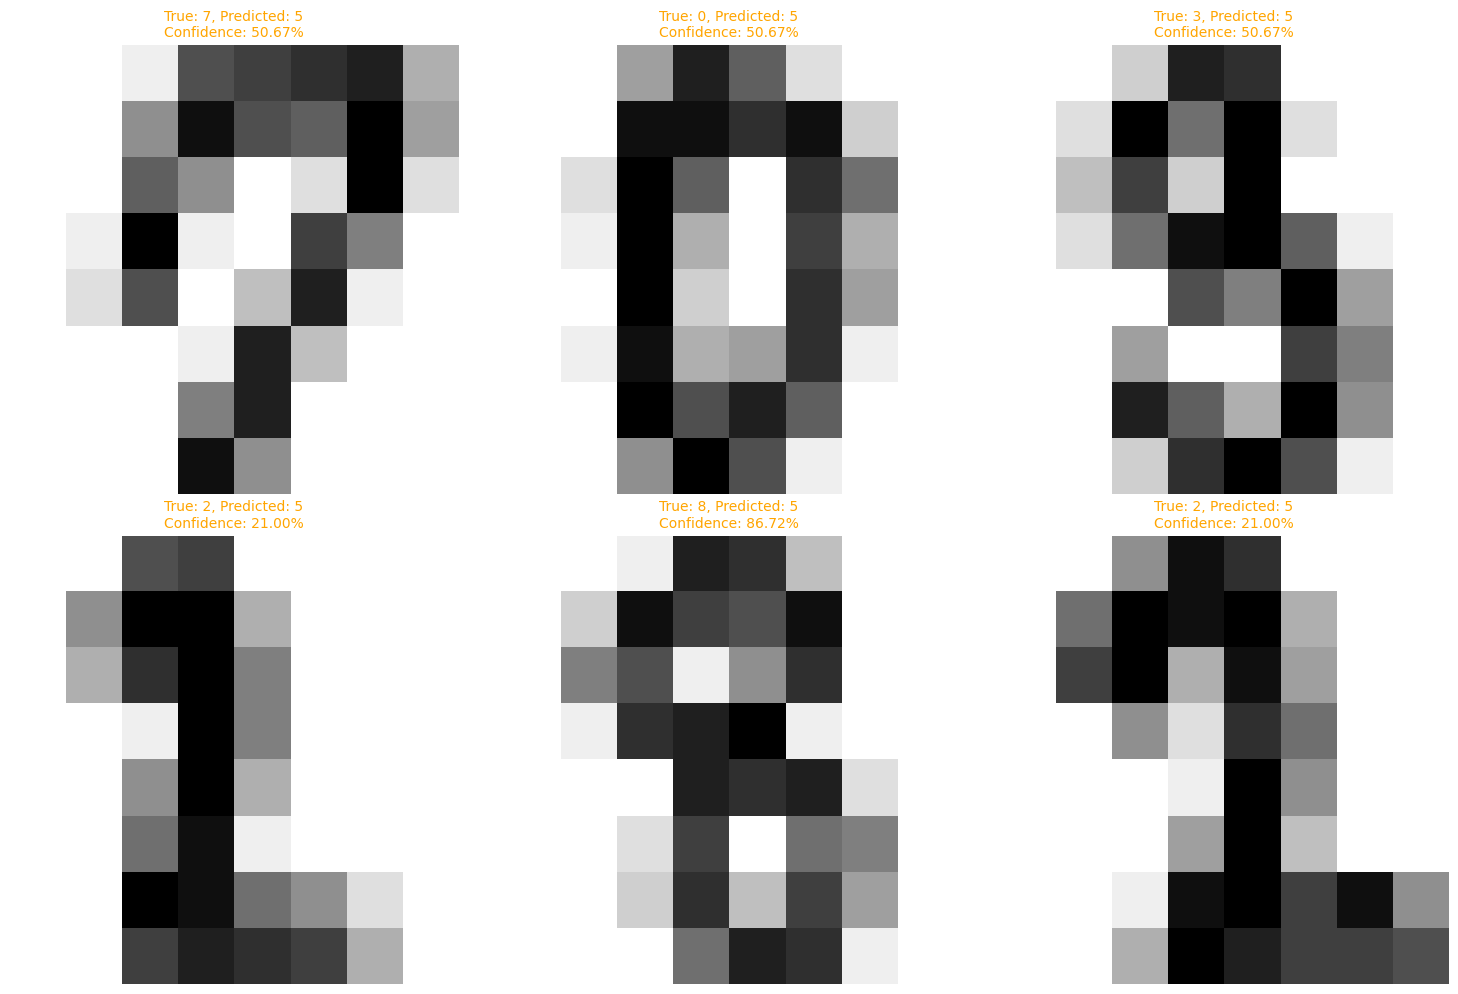


Detailed view of least confident mistakes:

Sample 1:
True label: 7, Predicted: 5, Confidence: 50.67%

Sample 2:
True label: 0, Predicted: 5, Confidence: 50.67%

Sample 3:
True label: 3, Predicted: 5, Confidence: 50.67%

ANALYSIS:

Looking at these misclassified examples:

1. CONFIDENT MISTAKES: These are cases where the model was very sure but wrong.
   - Often these are ambiguous digits that even humans might struggle with
   - The low resolution (8x8 pixels) makes some digits look very similar
   - Examples: 8 vs 3, 9 vs 4, 5 vs 8, etc.

2. UNCERTAIN MISTAKES: These are cases where the model was unsure and guessed wrong.
   - These are often more understandable errors
   - The model's uncertainty is reflected in more distributed probabilities
   - These might be easier to fix with more training or better features

Question: Would you have done any better?
- For many of these errors, even humans would struggle with the low resolution
- Some digits are genuinely ambiguous at 8x8 reso

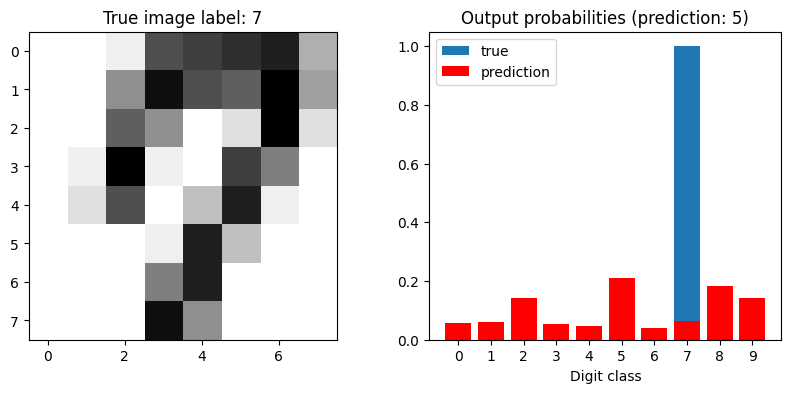

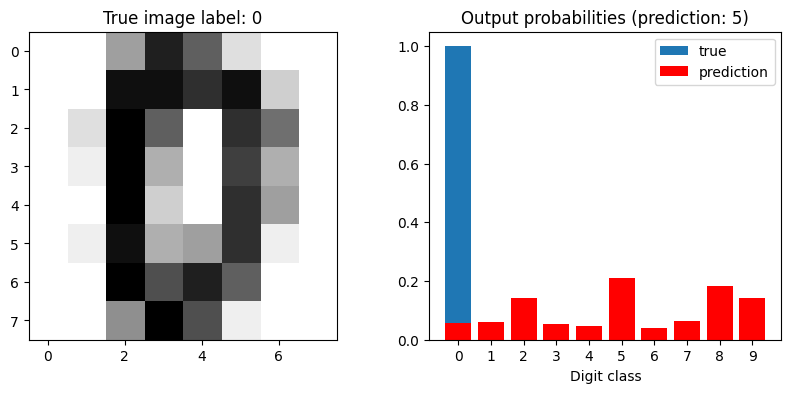

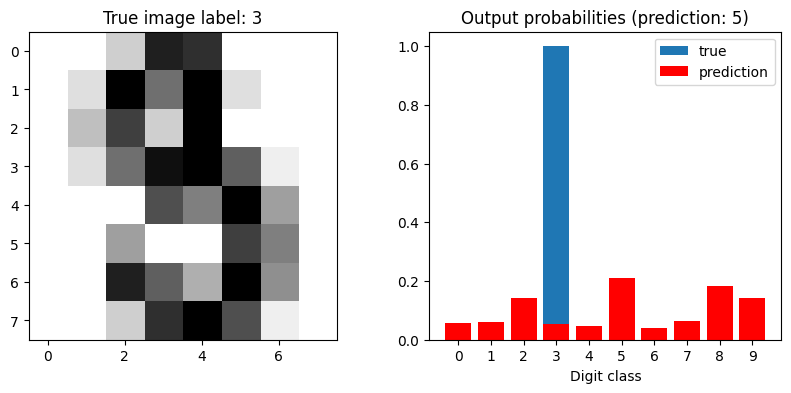

In [31]:
# Find and visualize the worst prediction errors

# Get predictions for all test samples
y_pred = model.predict(X_test)

# Compute the prediction probabilities for all test samples
y_probs = model.forward(X_test)

# Find samples where the model was wrong
incorrect_mask = (y_pred != y_test)
incorrect_indices = np.where(incorrect_mask)[0]

print(f"Total number of incorrect predictions: {len(incorrect_indices)} out of {len(y_test)}")
print(f"Error rate: {len(incorrect_indices) / len(y_test) * 100:.2f}%")

# For each incorrect prediction, calculate how confident the model was (max probability)
# We want the WORST predictions, which are those where the model was very confident but wrong
if len(incorrect_indices) > 0:
    # Get the predicted probabilities for incorrect samples
    incorrect_probs = y_probs[incorrect_indices]
    
    # Get the confidence (max probability) for each incorrect prediction
    confidences = np.max(incorrect_probs, axis=1)
    
    # Sort by confidence (descending) to find the most confident wrong predictions
    most_confident_wrong_indices = incorrect_indices[np.argsort(-confidences)]
    
    # Also find predictions where the model was most uncertain (lowest max probability)
    least_confident_wrong_indices = incorrect_indices[np.argsort(confidences)]
    
    print("\n" + "="*80)
    print("MOST CONFIDENT WRONG PREDICTIONS (model was very sure, but wrong)")
    print("="*80)
    
    # Plot the top 6 most confident wrong predictions
    n_samples = min(6, len(most_confident_wrong_indices))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(n_samples):
        sample_idx = most_confident_wrong_indices[i]
        ax = axes[i]
        
        # Create subplot for this prediction
        ax.imshow(X_test[sample_idx].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
        
        true_label = y_test[sample_idx]
        pred_label = y_pred[sample_idx]
        confidence = confidences[np.where(most_confident_wrong_indices == sample_idx)[0][0]]
        
        ax.set_title(f"True: {true_label}, Predicted: {pred_label}\nConfidence: {confidence:.2%}", 
                    fontsize=10, color='red')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Use the existing plot_prediction function for detailed view
    print("\nDetailed view of worst predictions (most confident mistakes):")
    for i in range(min(3, len(most_confident_wrong_indices))):
        sample_idx = most_confident_wrong_indices[i]
        print(f"\nSample {i+1}:")
        print(f"True label: {y_test[sample_idx]}, Predicted: {y_pred[sample_idx]}, "
              f"Confidence: {confidences[np.where(most_confident_wrong_indices == sample_idx)[0][0]]:.2%}")
        plot_prediction(model, sample_idx=sample_idx)
    
    print("\n" + "="*80)
    print("LEAST CONFIDENT WRONG PREDICTIONS (model was unsure and wrong)")
    print("="*80)
    
    # Plot the top 6 least confident wrong predictions
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(n_samples):
        sample_idx = least_confident_wrong_indices[i]
        ax = axes[i]
        
        ax.imshow(X_test[sample_idx].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
        
        true_label = y_test[sample_idx]
        pred_label = y_pred[sample_idx]
        confidence = confidences[np.where(least_confident_wrong_indices == sample_idx)[0][0]]
        
        ax.set_title(f"True: {true_label}, Predicted: {pred_label}\nConfidence: {confidence:.2%}", 
                    fontsize=10, color='orange')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed view of least confident mistakes:")
    for i in range(min(3, len(least_confident_wrong_indices))):
        sample_idx = least_confident_wrong_indices[i]
        print(f"\nSample {i+1}:")
        print(f"True label: {y_test[sample_idx]}, Predicted: {y_pred[sample_idx]}, "
              f"Confidence: {confidences[np.where(least_confident_wrong_indices == sample_idx)[0][0]]:.2%}")
        plot_prediction(model, sample_idx=sample_idx)

else:
    print("No incorrect predictions found! The model has 100% accuracy on the test set.")

print("\n" + "="*80)
print("ANALYSIS:")
print("="*80)
print("""
Looking at these misclassified examples:

1. CONFIDENT MISTAKES: These are cases where the model was very sure but wrong.
   - Often these are ambiguous digits that even humans might struggle with
   - The low resolution (8x8 pixels) makes some digits look very similar
   - Examples: 8 vs 3, 9 vs 4, 5 vs 8, etc.

2. UNCERTAIN MISTAKES: These are cases where the model was unsure and guessed wrong.
   - These are often more understandable errors
   - The model's uncertainty is reflected in more distributed probabilities
   - These might be easier to fix with more training or better features

Question: Would you have done any better?
- For many of these errors, even humans would struggle with the low resolution
- Some digits are genuinely ambiguous at 8x8 resolution
- The model is actually performing quite well given the constraints!
""")

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

EXPERIMENT 1: Testing Different Learning Rates

Training with learning rate: 0.0001
  Final train accuracy: 0.4086
  Final test accuracy: 0.3704

Training with learning rate: 0.001
  Final train accuracy: 0.4912
  Final test accuracy: 0.4556

Training with learning rate: 0.01
  Final train accuracy: 0.7145
  Final test accuracy: 0.7037

Training with learning rate: 0.1
  Final train accuracy: 0.8723
  Final test accuracy: 0.8444


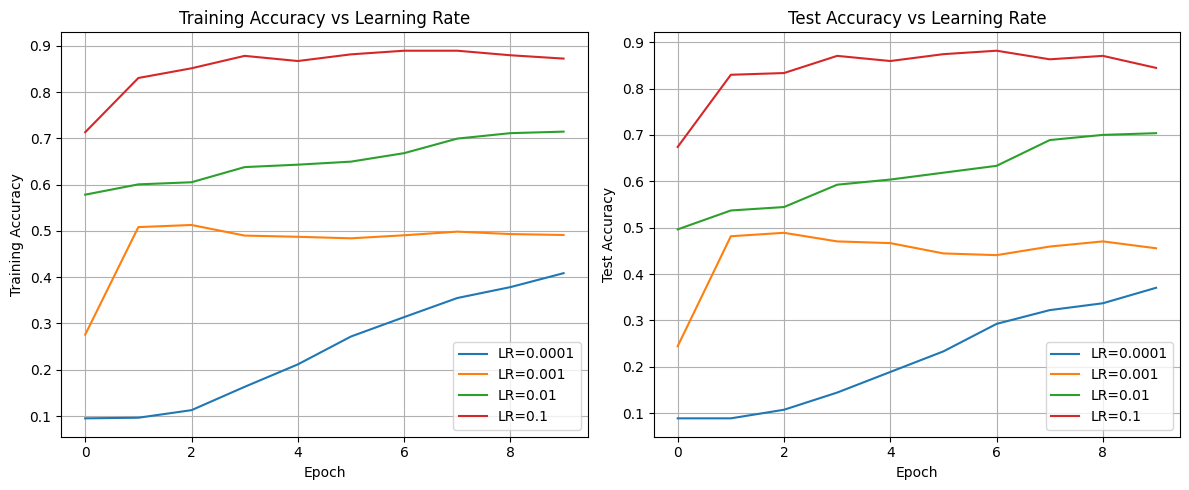


EXPERIMENT 2: Testing Different Hidden Layer Sizes

Training with hidden size: 5
  Final train accuracy: 0.4198
  Final test accuracy: 0.3519

Training with hidden size: 10
  Final train accuracy: 0.6012
  Final test accuracy: 0.5963

Training with hidden size: 20
  Final train accuracy: 0.8022
  Final test accuracy: 0.8185

Training with hidden size: 50
  Final train accuracy: 0.8867
  Final test accuracy: 0.8926

Training with hidden size: 100
  Final train accuracy: 0.9417
  Final test accuracy: 0.9296


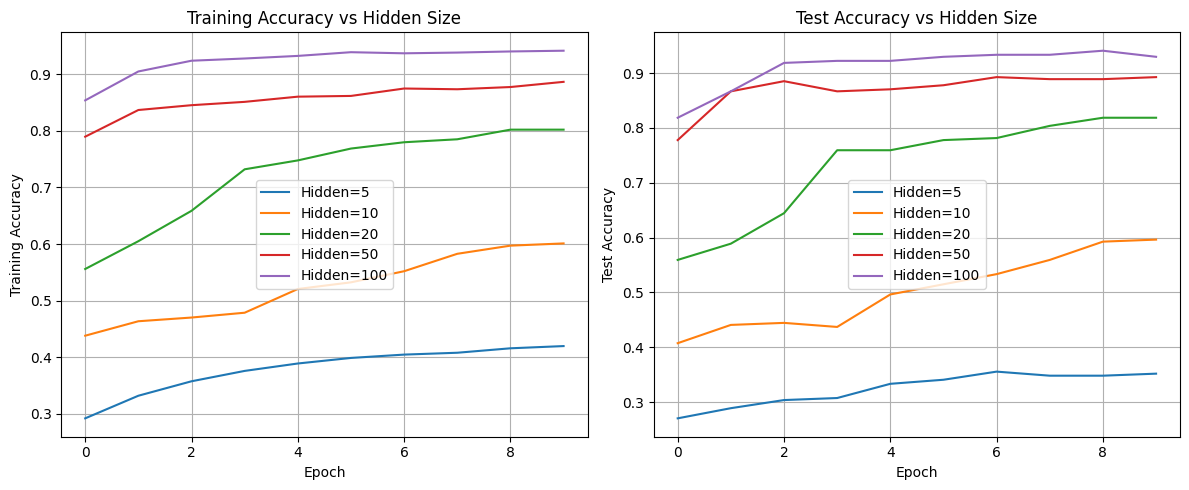


EXPERIMENT 3: Neural Network with TWO Hidden Layers

Testing different architectures with 2 hidden layers:

Training with architecture: 64->20->10->10
  Final train accuracy: 0.4630
  Final test accuracy: 0.4481

Training with architecture: 64->30->15->10
  Final train accuracy: 0.5743
  Final test accuracy: 0.5222

Training with architecture: 64->50->25->10
  Final train accuracy: 0.6994
  Final test accuracy: 0.6778

Training with architecture: 64->64->32->10
  Final train accuracy: 0.7845
  Final test accuracy: 0.8296


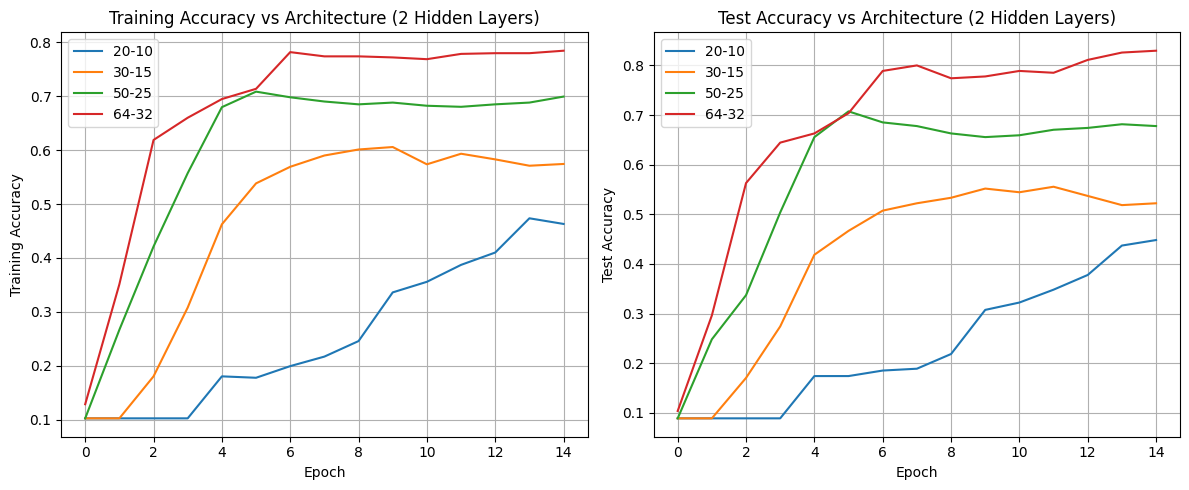


SUMMARY OF BEST RESULTS

Best Learning Rate:
  LR = 0.1, Test Accuracy = 0.8444

Best Hidden Size (1 layer):
  Hidden Size = 100, Test Accuracy = 0.9296

Best Architecture (2 layers):
  Architecture = 64-32, Test Accuracy = 0.8296

KEY INSIGHTS:

1. LEARNING RATE:
   - Too small (0.0001): Very slow convergence
   - Too large (0.1): May overshoot and be unstable
   - Sweet spot: Usually around 0.001-0.01 for this problem

2. HIDDEN LAYER SIZE:
   - Larger hidden layers can capture more complex patterns
   - But too large can lead to overfitting on small datasets
   - Diminishing returns after a certain size

3. TWO HIDDEN LAYERS:
   - Deeper networks can learn more complex representations
   - But also harder to train (vanishing gradients with sigmoid)
   - May require more careful tuning of learning rate and initialization
   - With modern activation functions (ReLU), deeper networks work much better!

4. OVERALL:
   - The best test accuracy is achieved through careful tuning of all h

In [33]:
# Hyperparameter tuning experiments

print("="*80)
print("EXPERIMENT 1: Testing Different Learning Rates")
print("="*80)

learning_rates = [0.0001, 0.001, 0.01, 0.1]
lr_results = {}

for lr_val in learning_rates:
    print(f"\nTraining with learning rate: {lr_val}")
    
    # Create and train model
    model_lr = NeuralNet(n_features, hidden_size=10, output_size=n_classes)
    
    
    train_accs = []
    test_accs = []
    
    for epoch in range(10):
        for x, y in zip(X_train, y_train):
            model_lr.train(x, y, lr_val)
        
        train_accs.append(model_lr.accuracy(X_train, y_train))
        test_accs.append(model_lr.accuracy(X_test, y_test))
    
    lr_results[lr_val] = {
        'train': train_accs,
        'test': test_accs,
        'final_test': test_accs[-1]
    }
    
    print(f"  Final train accuracy: {train_accs[-1]:.4f}")
    print(f"  Final test accuracy: {test_accs[-1]:.4f}")

# Plot learning rate comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for lr_val, results in lr_results.items():
    plt.plot(results['train'], label=f'LR={lr_val}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Learning Rate')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for lr_val, results in lr_results.items():
    plt.plot(results['test'], label=f'LR={lr_val}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Learning Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("EXPERIMENT 2: Testing Different Hidden Layer Sizes")
print("="*80)

hidden_sizes = [5, 10, 20, 50, 100]
hs_results = {}

for hs in hidden_sizes:
    print(f"\nTraining with hidden size: {hs}")
    
    model_hs = NeuralNet(n_features, hidden_size=hs, output_size=n_classes)
    
    train_accs = []
    test_accs = []
    
    for epoch in range(10):
        for x, y in zip(X_train, y_train):
            model_hs.train(x, y, 0.01)
        
        train_accs.append(model_hs.accuracy(X_train, y_train))
        test_accs.append(model_hs.accuracy(X_test, y_test))
    
    hs_results[hs] = {
        'train': train_accs,
        'test': test_accs,
        'final_test': test_accs[-1]
    }
    
    print(f"  Final train accuracy: {train_accs[-1]:.4f}")
    print(f"  Final test accuracy: {test_accs[-1]:.4f}")

# Plot hidden size comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for hs, results in hs_results.items():
    plt.plot(results['train'], label=f'Hidden={hs}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Hidden Size')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for hs, results in hs_results.items():
    plt.plot(results['test'], label=f'Hidden={hs}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Hidden Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("EXPERIMENT 3: Neural Network with TWO Hidden Layers")
print("="*80)

class NeuralNetTwoHidden():
    """MLP with 2 hidden layers with sigmoid activations"""

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        # Initialize weights for first hidden layer
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size_1),
                                      high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden_size_1,
                                      high=0.1, low=-0.1)
        
        # Initialize weights for second hidden layer
        self.W_h2 = np.random.uniform(size=(hidden_size_1, hidden_size_2),
                                      high=0.1, low=-0.1)
        self.b_h2 = np.random.uniform(size=hidden_size_2,
                                      high=0.1, low=-0.1)
        
        # Initialize weights for output layer
        self.W_o = np.random.uniform(size=(hidden_size_2, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size

    def forward(self, X):
        # First hidden layer
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        self.A_h1 = sigmoid(self.Z_h1)
        
        # Second hidden layer
        self.Z_h2 = np.dot(self.A_h1, self.W_h2) + self.b_h2
        self.A_h2 = sigmoid(self.Z_h2)
        
        # Output layer
        self.Z_o = np.dot(self.A_h2, self.W_o) + self.b_o
        Y = sigmoid(self.Z_o)
        
        return Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y.astype(int))
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred) / len(y)

    def grad_loss(self, X, y_true):
        y_true_onehot = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Backprop through output layer
        error_o = y_pred - y_true_onehot
        grad_W_o = np.dot(self.A_h2.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Backprop through second hidden layer
        error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.A_h2)
        grad_W_h2 = np.dot(self.A_h1.T, error_h2)
        grad_b_h2 = np.sum(error_h2, axis=0)
        
        # Backprop through first hidden layer
        error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.A_h1)
        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)

        return {
            "W_h1": grad_W_h1, "b_h1": grad_b_h1,
            "W_h2": grad_W_h2, "b_h2": grad_b_h2,
            "W_o": grad_W_o, "b_o": grad_b_o
        }

    def train(self, x, y, learning_rate):
        x = x[np.newaxis, :]
        grads = self.grad_loss(x, y)
        
        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_h2 -= learning_rate * grads["W_h2"]
        self.b_h2 -= learning_rate * grads["b_h2"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X[np.newaxis, :]))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = self.predict(X)
        return np.mean(y_preds == y)

print("\nTesting different architectures with 2 hidden layers:")
architectures = [
    (20, 10),
    (30, 15),
    (50, 25),
    (64, 32),
]

arch_results = {}

for h1, h2 in architectures:
    print(f"\nTraining with architecture: {n_features}->{h1}->{h2}->{n_classes}")
    
    model_2h = NeuralNetTwoHidden(n_features, h1, h2, n_classes)
    
    train_accs = []
    test_accs = []
    
    for epoch in range(15):
        for x, y in zip(X_train, y_train):
            model_2h.train(x, y, 0.01)
        
        train_accs.append(model_2h.accuracy(X_train, y_train))
        test_accs.append(model_2h.accuracy(X_test, y_test))
    
    arch_results[f"{h1}-{h2}"] = {
        'train': train_accs,
        'test': test_accs,
        'final_test': test_accs[-1]
    }
    
    print(f"  Final train accuracy: {train_accs[-1]:.4f}")
    print(f"  Final test accuracy: {test_accs[-1]:.4f}")

# Plot architecture comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for arch, results in arch_results.items():
    plt.plot(results['train'], label=f'{arch}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Architecture (2 Hidden Layers)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for arch, results in arch_results.items():
    plt.plot(results['test'], label=f'{arch}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Architecture (2 Hidden Layers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY OF BEST RESULTS")
print("="*80)

print("\nBest Learning Rate:")
best_lr = max(lr_results.items(), key=lambda x: x[1]['final_test'])
print(f"  LR = {best_lr[0]}, Test Accuracy = {best_lr[1]['final_test']:.4f}")

print("\nBest Hidden Size (1 layer):")
best_hs = max(hs_results.items(), key=lambda x: x[1]['final_test'])
print(f"  Hidden Size = {best_hs[0]}, Test Accuracy = {best_hs[1]['final_test']:.4f}")

print("\nBest Architecture (2 layers):")
best_arch = max(arch_results.items(), key=lambda x: x[1]['final_test'])
print(f"  Architecture = {best_arch[0]}, Test Accuracy = {best_arch[1]['final_test']:.4f}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("""
1. LEARNING RATE:
   - Too small (0.0001): Very slow convergence
   - Too large (0.1): May overshoot and be unstable
   - Sweet spot: Usually around 0.001-0.01 for this problem

2. HIDDEN LAYER SIZE:
   - Larger hidden layers can capture more complex patterns
   - But too large can lead to overfitting on small datasets
   - Diminishing returns after a certain size

3. TWO HIDDEN LAYERS:
   - Deeper networks can learn more complex representations
   - But also harder to train (vanishing gradients with sigmoid)
   - May require more careful tuning of learning rate and initialization
   - With modern activation functions (ReLU), deeper networks work much better!

4. OVERALL:
   - The best test accuracy is achieved through careful tuning of all hyperparameters
   - More complex models don't always mean better performance
   - Need to balance model capacity with training time and overfitting risk
""")